# Tutorial 9 

In [1]:
%reset -f

### Load all Packages

In [2]:
import pandas            as pd
import matplotlib.pyplot as plt
import matplotlib.dates  as mdates
import seaborn           as sns
import numpy             as np
import statsmodels.api   as sm

from statsmodels.tsa.api                 import VAR
from statsmodels.tsa.stattools           import adfuller
from statsmodels.tsa.vector_ar.var_model import VARResults
from statsmodels.tsa.ardl                import ARDL

In [ ]:
sns.set_style('darkgrid')
pd.plotting.register_matplotlib_converters()
sns.mpl.rc('figure',figsize=(16, 6))

### Load Data

In [3]:
df = pd.read_stata("Kilian2009old.dta")

In [4]:
df.head()

,oil,output,price,time
0,11.877264,36.064236,-47.999535,1973-02-01
1,1.419150,41.527016,-48.286472,1973-03-01
2,1.177711,43.991249,-47.082500,1973-04-01
3,27.455135,48.105888,-43.857651,1973-05-01
4,-13.110436,52.033463,-41.571064,1973-06-01


In [5]:
df.tail()

,oil,output,price,time
414,-11.455108,47.054657,60.214855,2007-08-01
415,14.142312,50.869389,65.459709,2007-09-01
416,10.104911,56.806755,73.676384,2007-10-01
417,-3.038820,57.274223,81.208618,2007-11-01
418,7.315859,56.824303,78.115410,2007-12-01


In [6]:
df.index = pd.date_range(start='1973-02', periods=419, freq='MS')
df.drop(['time'], axis=1, inplace=True)

In [7]:
df

,oil,output,price
1973-02-01,11.877264,36.064236,-47.999535
1973-03-01,1.419150,41.527016,-48.286472
1973-04-01,1.177711,43.991249,-47.082500
1973-05-01,27.455135,48.105888,-43.857651
1973-06-01,-13.110436,52.033463,-41.571064
...,...,...,...
2007-08-01,-11.455108,47.054657,60.214855
2007-09-01,14.142312,50.869389,65.459709
2007-10-01,10.104911,56.806755,73.676384
2007-11-01,-3.038820,57.274223,81.208618


### Lets check stationarity

In [8]:
df1 = pd.DataFrame()
df2 = pd.DataFrame()
df3 = pd.DataFrame()

df1['data'] = df['oil']
df2['data'] = df['output']
df3['data'] = df['price']

In [9]:
def plot_rolling(df,name):
    
    df['z_data'] = (df['data'] - df.data.rolling(window=4).mean()) / df.data.rolling(window=4).std()
    df['zp_data'] = df['z_data'] - df['z_data'].shift(1)
    df['zs_data'] = df['z_data'] - df['z_data'].shift(4)
    
    fig, ax = plt.subplots(4,figsize=(12, 9))
    ax[0].scatter(df.index, df.data, color='c', label=name)
    ax[0].plot(df.data.rolling(window=4).mean(), color='b', label="moving avergae");
    ax[0].plot(df.data.rolling(window=4).std(), color='r', label="moving std");
    ax[0].legend()

    ax[1].scatter(df.index, df.z_data, color='c', label="de-trended "+name)
    ax[1].plot(df.z_data.rolling(window=4).mean(), color='b', label="moving aveage");
    ax[1].plot(df.z_data.rolling(window=4).std(), color='r', label="moving std");
    ax[1].legend()

    ax[2].scatter(df.index, df.zp_data, color='c', label="1 lag differenced de-trended "+name)
    ax[2].plot(df.zp_data.rolling(window=4).mean(), color='b', label="moving average");
    ax[2].plot(df.zp_data.rolling(window=4).std(), color='r', label="moving std");
    ax[2].legend()
    
    ax[3].scatter(df.index, df.zs_data, color='c', label="seasonal differenced de-trended "+name)
    ax[3].plot(df.zs_data.rolling(window=4).mean(), color='b', label="moving average");
    ax[3].plot(df.zs_data.rolling(window=4).std(), color='r', label="moving std");
    ax[3].legend()

    plt.tight_layout()
    fig.autofmt_xdate()
    

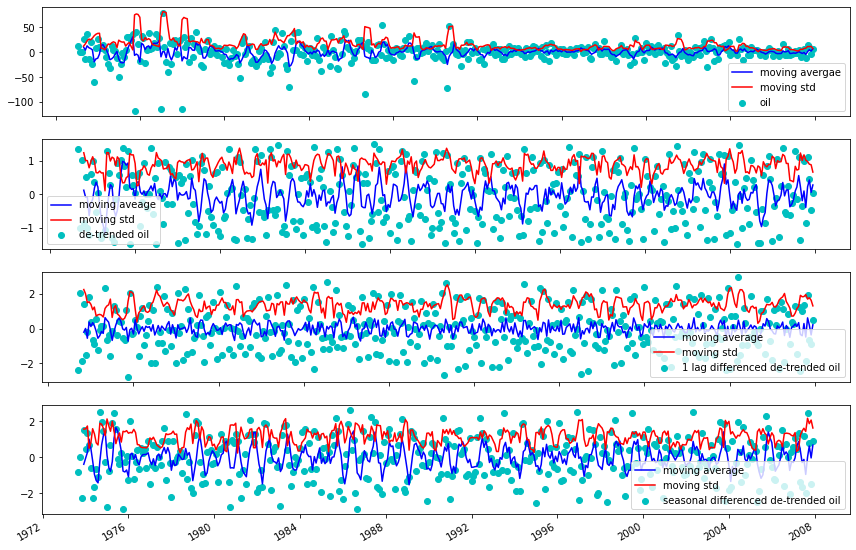

In [10]:
plot_rolling(df1,'oil')

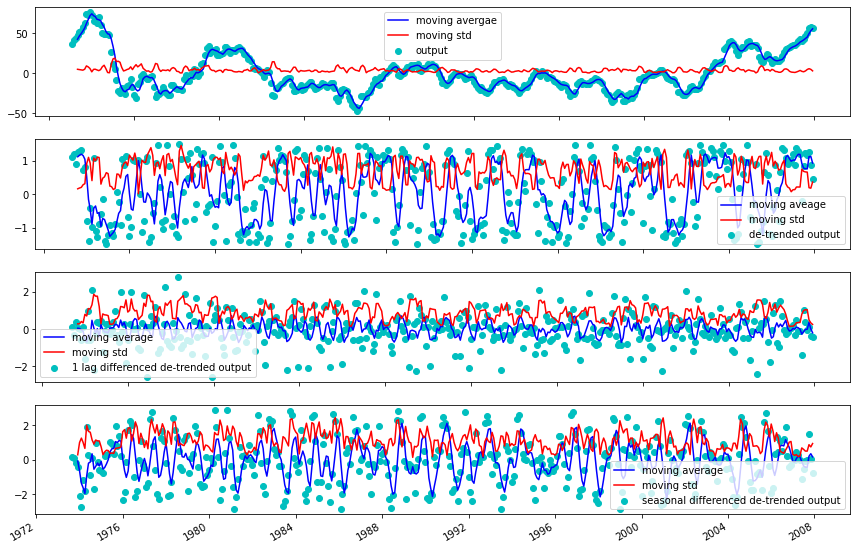

In [11]:
plot_rolling(df2,'output')

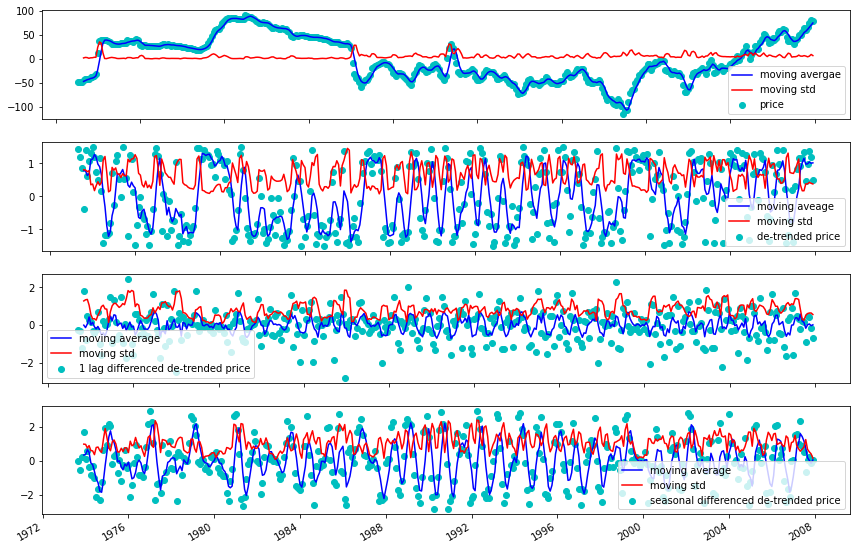

In [12]:
plot_rolling(df3,'price')

### ADF Test

In [14]:
def adf_test(df,name):
    
    print("-----------------------------------------")
    print("for variable " + name)
    print("-----------------------------------------")
    
    dftest = adfuller(df.data.dropna(), autolag='BIC')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

    print("\n > Is the de-trended data stationary ?")
    dftest = adfuller(df.z_data.dropna(), autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

    print("\n > Is the 1-lag differenced de-trended data stationary ?")
    dftest = adfuller(df.zp_data.dropna(), autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
    print("\n > Is the seasonal differenced de-trended data stationary ?")
    dftest = adfuller(df.zs_data.dropna(), autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

In [15]:
adf_test(df1,'oil')

-----------------------------------------
for variable oil
-----------------------------------------
Test statistic = -22.347
P-value = 0.000
Critical values :
	1%: -3.4460914174990296 - The data is  stationary with 99% confidence
	5%: -2.868479374038333 - The data is  stationary with 95% confidence
	10%: -2.570466459559076 - The data is  stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -11.883
P-value = 0.000
Critical values :
	1%: -3.4464005219454155 - The data is  stationary with 99% confidence
	5%: -2.868615280538588 - The data is  stationary with 95% confidence
	10%: -2.570538905413444 - The data is  stationary with 90% confidence

 > Is the 1-lag differenced de-trended data stationary ?
Test statistic = -10.368
P-value = 0.000
Critical values :
	1%: -3.446845912589748 - The data is  stationary with 99% confidence
	5%: -2.8688110853002007 - The data is  stationary with 95% confidence
	10%: -2.5706432834592747 - The data is  stationary with 90

In [16]:
adf_test(df2,'output')

-----------------------------------------
for variable output
-----------------------------------------
Test statistic = -2.567
P-value = 0.100
Critical values :
	1%: -3.446129402876608 - The data is not stationary with 99% confidence
	5%: -2.8684960761128346 - The data is not stationary with 95% confidence
	10%: -2.570475362616382 - The data is not stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -5.960
P-value = 0.000
Critical values :
	1%: -3.4467631030732506 - The data is  stationary with 99% confidence
	5%: -2.868774682311516 - The data is  stationary with 95% confidence
	10%: -2.570623877774392 - The data is  stationary with 90% confidence

 > Is the 1-lag differenced de-trended data stationary ?
Test statistic = -7.484
P-value = 0.000
Critical values :
	1%: -3.446845912589748 - The data is  stationary with 99% confidence
	5%: -2.8688110853002007 - The data is  stationary with 95% confidence
	10%: -2.5706432834592747 - The data is  stationar

In [17]:
adf_test(df3,'price')

-----------------------------------------
for variable price
-----------------------------------------
Test statistic = -2.269
P-value = 0.182
Critical values :
	1%: -3.446129402876608 - The data is not stationary with 99% confidence
	5%: -2.8684960761128346 - The data is not stationary with 95% confidence
	10%: -2.570475362616382 - The data is not stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -5.607
P-value = 0.000
Critical values :
	1%: -3.4466811208382437 - The data is  stationary with 99% confidence
	5%: -2.8687386420385494 - The data is  stationary with 95% confidence
	10%: -2.5706046655665635 - The data is  stationary with 90% confidence

 > Is the 1-lag differenced de-trended data stationary ?
Test statistic = -7.685
P-value = 0.000
Critical values :
	1%: -3.4469717056192213 - The data is  stationary with 99% confidence
	5%: -2.868866381945153 - The data is  stationary with 95% confidence
	10%: -2.570672761197837 - The data is  stationar

### We need to first diff price and output to make the series stationary

In [18]:
df['price']  = df['price'].diff(1)
df['output'] = df['output'].diff(1)

df = df.dropna()

df.head()

,oil,output,price
1973-03-01,1.419150,5.462780,-0.286938
1973-04-01,1.177711,2.464233,1.203972
1973-05-01,27.455135,4.114639,3.224850
1973-06-01,-13.110436,3.927574,2.286587
1973-07-01,36.258072,0.909397,0.583103


In [19]:
df = df.rename(columns={"output" : "D1_output"})
df = df.rename(columns={"price"  : "D1_price"})

df.head()

,oil,D1_output,D1_price
1973-03-01,1.419150,5.462780,-0.286938
1973-04-01,1.177711,2.464233,1.203972
1973-05-01,27.455135,4.114639,3.224850
1973-06-01,-13.110436,3.927574,2.286587
1973-07-01,36.258072,0.909397,0.583103


### Q2

#### (a).

In [20]:
def var_est_BIC(df,i):
    
    print("---------------------------------------------")
    print("VAR result for lag = " + str(i))
    print("---------------------------------------------")
    
    model  = VAR(df)
    result = model.fit(maxlags=i, ic='bic', trend='c',verbose=True)
    
    print(result.summary())
    
    print("---------------------------------------------")
    print("Plotting input time series")
    print("---------------------------------------------")
    
    result.plot()
    plt.show()
    
    print("---------------------------------------------")
    print("Plotting time series autocorrelation function")
    print("---------------------------------------------")
          
    result.plot_acorr()
    plt.show()
    
    print("---------------------------------------------")
    print("Plotting IRF")
    print("---------------------------------------------")
    
    irf = result.irf(10)
    irf.plot(orth=False)
    plt.show()
    
    print("---------------------------------------------")
    print("Plotting cumulative effects")
    print("---------------------------------------------")
    
    irf.plot_cum_effects(orth=False)
    plt.show()
    
    print("---------------------------------------------")
    print("Granger test")
    print("---------------------------------------------")
    
    test_result1 = result.test_causality('oil', ['D1_output', 'D1_price'], kind='f')
    print(test_result1.summary())
    
    test_result2 = result.test_causality('D1_price', ['oil', 'D1_output'], kind='f')
    print(test_result2.summary())
    
    test_result3 = result.test_causality('D1_output', ['D1_price', 'oil'], kind='f')
    print(test_result3.summary())
    
    print("---------------------------------------------")
    print("Ljung-Box test for VAR")
    print("---------------------------------------------")
    test_result4 = result.test_whiteness()
    print(test_result4.summary())
    

---------------------------------------------
VAR result for lag = 1
---------------------------------------------
<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 1, BIC -> 1, FPE -> 1, HQIC ->  1>
Using 1 based on bic criterion
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 18, Oct, 2022
Time:                     18:40:17
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    12.9267
Nobs:                     417.000    HQIC:                   12.8565
Log likelihood:          -4434.11    FPE:                    366084.
AIC:                      12.8106    Det(Omega_mle):         355748.
--------------------------------------------------------------------
Results for equation oil
                  coefficient       std. error           t-stat            prob
------------------------------------

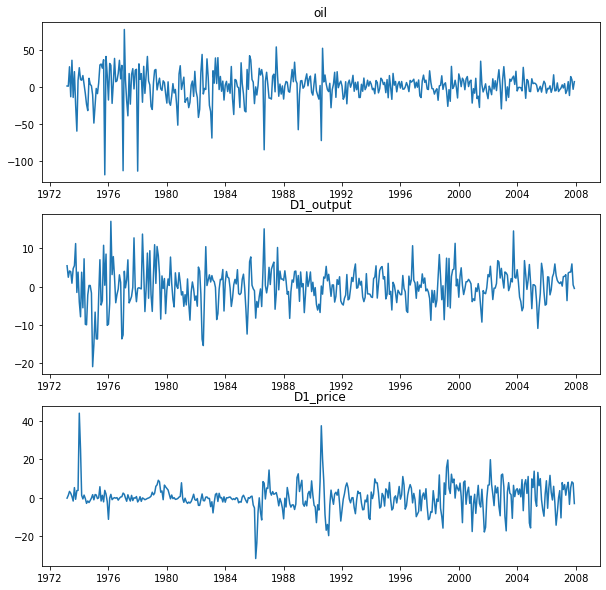

---------------------------------------------
Plotting time series autocorrelation function
---------------------------------------------


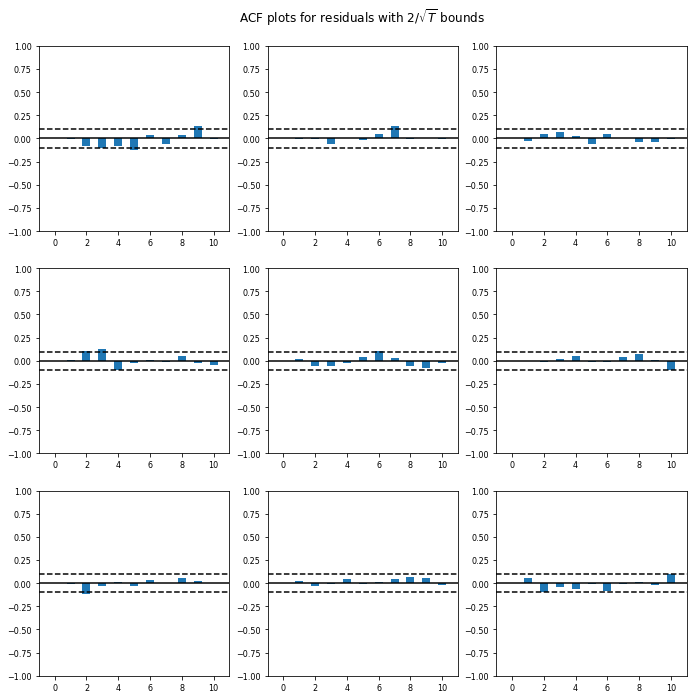

---------------------------------------------
Plotting IRF
---------------------------------------------


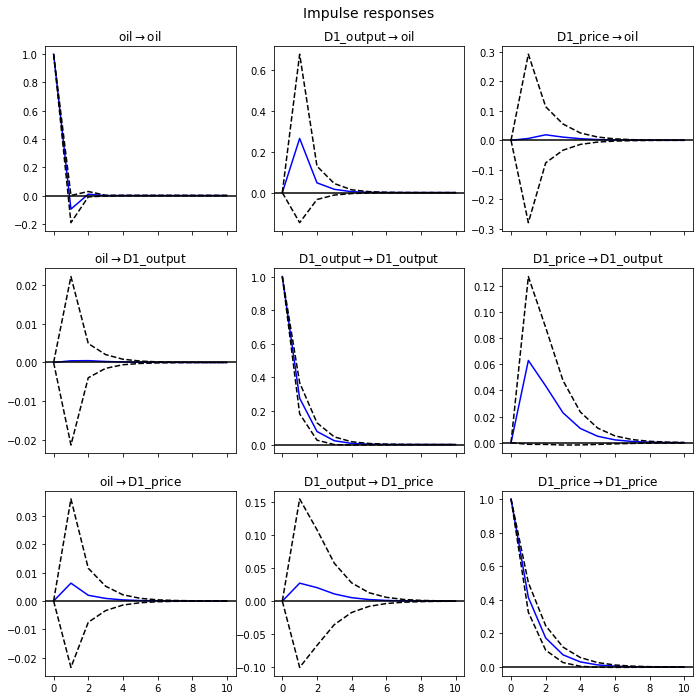

---------------------------------------------
Plotting cumulative effects
---------------------------------------------


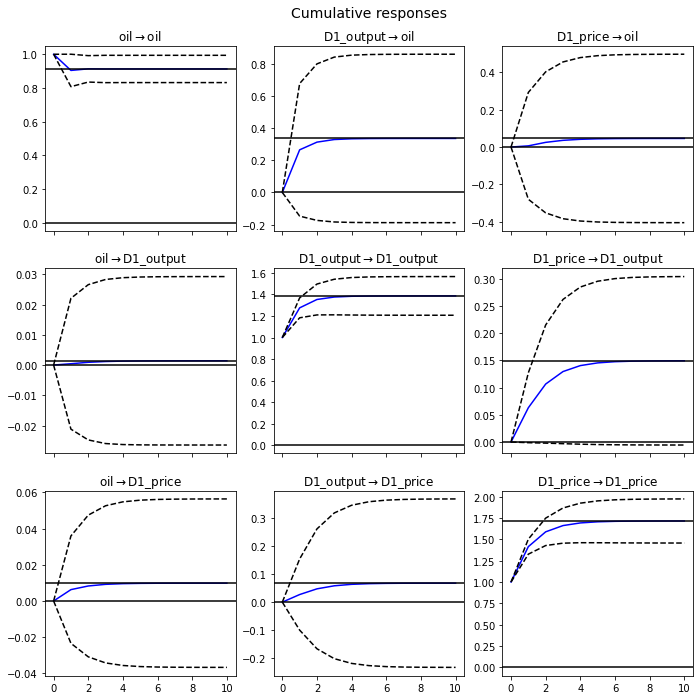

---------------------------------------------
Granger test
---------------------------------------------
Granger causality F-test. H_0: ['D1_output', 'D1_price'] do not Granger-cause oil. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
        0.8049          3.003   0.447 (2, 1239)
-----------------------------------------------
Granger causality F-test. H_0: ['oil', 'D1_output'] do not Granger-cause D1_price. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
        0.1896          3.003   0.827 (2, 1239)
-----------------------------------------------
Granger causality F-test. H_0: ['D1_price', 'oil'] do not Granger-cause D1_output. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-------------------------------------------

In [22]:
var_est_BIC(df,1)

#### (b).

In [23]:
df.columns.tolist()

['oil', 'D1_output', 'D1_price']

###### lets change around the row order of Y vector and then reselected the model order

In [24]:
cols_new = ['D1_output', 'oil', 'D1_price']

df_new = df[cols_new]

---------------------------------------------
VAR result for lag = 1
---------------------------------------------
<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 1, BIC -> 1, FPE -> 1, HQIC ->  1>
Using 1 based on bic criterion
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 18, Oct, 2022
Time:                     18:41:17
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    12.9267
Nobs:                     417.000    HQIC:                   12.8565
Log likelihood:          -4434.11    FPE:                    366084.
AIC:                      12.8106    Det(Omega_mle):         355748.
--------------------------------------------------------------------
Results for equation D1_output
                  coefficient       std. error           t-stat            prob
------------------------------

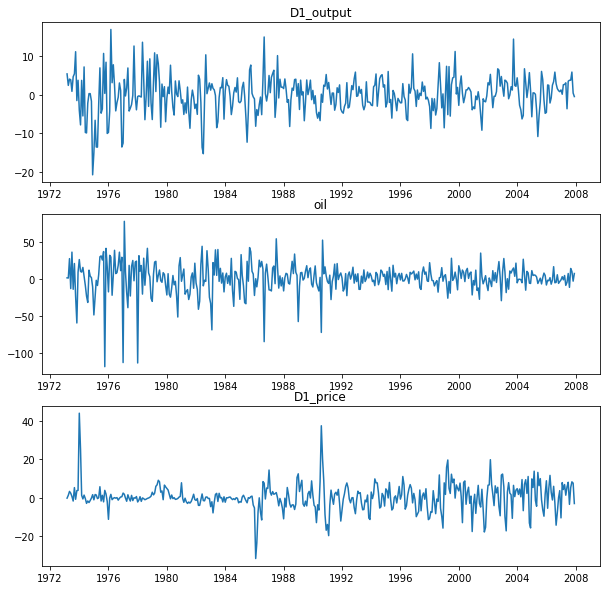

---------------------------------------------
Plotting time series autocorrelation function
---------------------------------------------


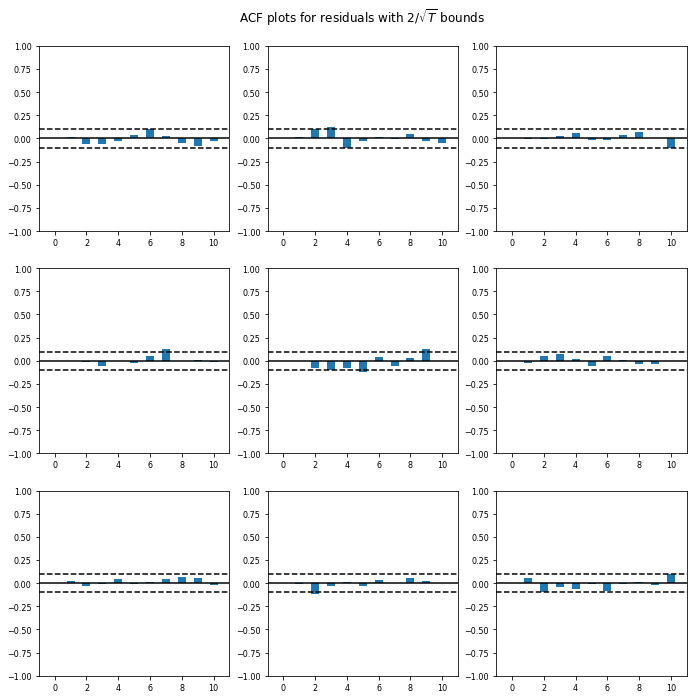

---------------------------------------------
Plotting IRF
---------------------------------------------


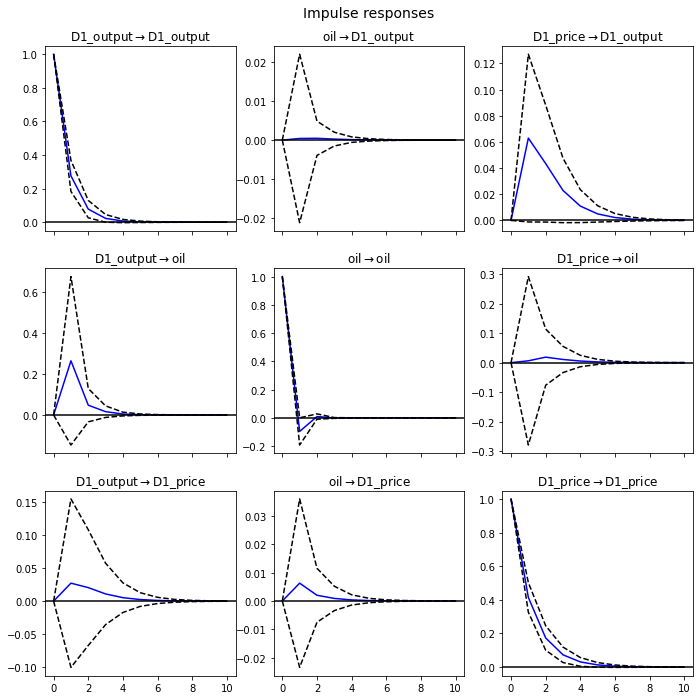

---------------------------------------------
Plotting cumulative effects
---------------------------------------------


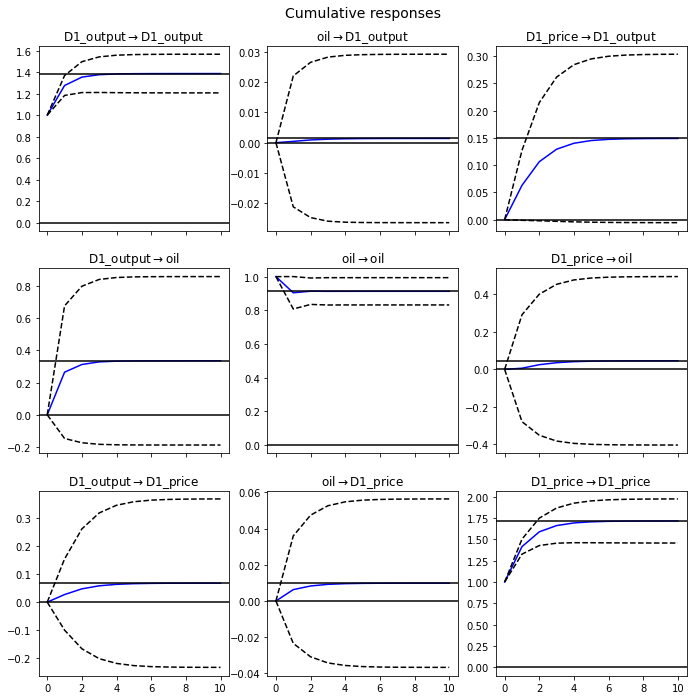

---------------------------------------------
Granger test
---------------------------------------------
Granger causality F-test. H_0: ['D1_output', 'D1_price'] do not Granger-cause oil. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
        0.8049          3.003   0.447 (2, 1239)
-----------------------------------------------
Granger causality F-test. H_0: ['oil', 'D1_output'] do not Granger-cause D1_price. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
        0.1896          3.003   0.827 (2, 1239)
-----------------------------------------------
Granger causality F-test. H_0: ['D1_price', 'oil'] do not Granger-cause D1_output. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-------------------------------------------

In [25]:
var_est_BIC(df_new, 1)